In [1]:
import tensorflow as tf
from model.seq2seq import bilstm, lstm, gru
import numpy as np
from utils.text_processing import load_dict_from_vocab_file

vocab_file = './data/character_inventory_unk.txt'
traindb_file = './data/training.npz'
testdb_file = './data/testing.npz'
checkpoint_file = './tfmodel/gru_enc/model_800.tfmodel'

/home/dustin/python_envs/p3MachineLearning/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Get the embeddings

In [2]:
vocab = load_dict_from_vocab_file(vocab_file)
vocab_size = len(vocab)
lstm_dim = 500

In [3]:
with tf.name_scope("placeholders"):
    encoder_in = tf.placeholder(tf.int32, [None, None])
    encoder_lens = tf.placeholder(tf.int32, [None])
    batch_size = tf.placeholder(tf.int32)

with tf.name_scope("model"):
    enc_emb = tf.one_hot(encoder_in, vocab_size)
    with tf.name_scope("encoder"):
        encoder_state = gru(enc_emb, encoder_lens, lstm_dim, batch_size=batch_size, scope='gru')
        
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, checkpoint_file)

INFO:tensorflow:Restoring parameters from ./tfmodel/gru_enc/model_800.tfmodel


In [4]:
data = np.load(testdb_file)
encoder_in_batch = data['enc_in']
encoder_len_batch = data['enc_lens']

embeddings = sess.run(encoder_state, feed_dict={encoder_in: encoder_in_batch, 
                                                   encoder_lens: encoder_len_batch,
                                                   batch_size: encoder_in_batch.shape[0]})

## PCA

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpld3

%matplotlib notebook
mpld3.enable_notebook()

def scatterPlotWithLabels(ax,x,y,z=[], pointSize=5,labels=None,color='red'):
    if len(z) > 0:
        handle = ax.scatter(x, y, z, c=color, s=pointSize)
    else:
        handle = ax.scatter(x, y, c=color, s=pointSize)
    
    if labels is not None:
        tooltip = mpld3.plugins.PointLabelTooltip(handle, labels=labels)
        mpld3.plugins.connect(plt.gcf(), tooltip)
    return handle

def get_cmap(n, name='RdYlBu'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plotSamples(classes, xform, classnames, projection=None, title=None): 
    colormap = get_cmap(len(classes))
    fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(right=0.8)
    ax = plt.subplot(facecolor='#EEEEEE', projection=projection)
    #ax.grid(color='white', linestyle='solid')
    if title is not None:
        ax.set_title(title, fontsize=30)
    handles = []
    labels = []
    point_labels = []
    for i,c in enumerate(classes):
        plot_data = xform.transform(c)
        if projection and projection in '3d':
            ex = scatterPlotWithLabels(ax, plot_data[:,0], plot_data[:,1], plot_data[:,2], color=colormap(i))
        else:
            ex = scatterPlotWithLabels(ax, plot_data[:,0], plot_data[:,1], color=colormap(i))

        handles.append(ex)
        labels.append(classnames[i])

#     handles, labels = ax.get_legend_handles_labels() # return lines and labels
#     interactive_legend = mpld3.plugins.InteractiveLegendPlugin(zip(handles,
#                                                              ax.collections),
#                                                          labels,
#                                                          #alpha_unsel=0.5,
#                                                          #alpha_over=1.5, 
#                                                          start_visible=True)
#     #ax.legend(handles, labels, markerscale=0.5)
#     mpld3.plugins.connect(fig, interactive_legend)

In [12]:
from sklearn.decomposition import PCA
import pandas as pd

data = pd.read_csv('./data/testing.txt', sep='\t')
classes = [d.split(';')[0] for d in data.values[:,3]]
embed_pca = PCA(n_components=3)
embed_decomp = embed_pca.fit(embeddings)

<IPython.core.display.Javascript object>


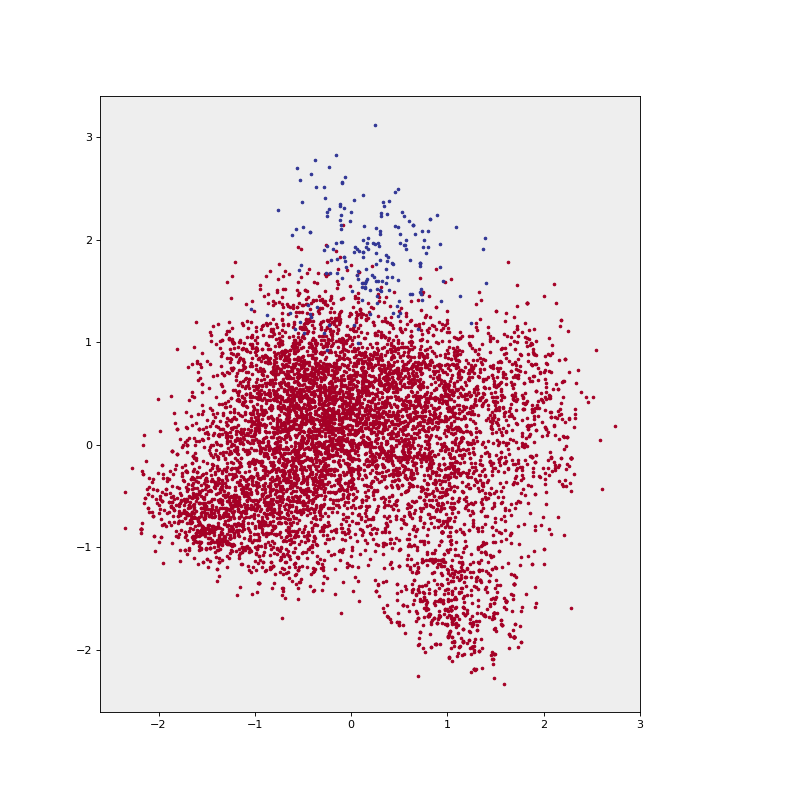

In [13]:
from itertools import groupby
classnames = [j for j,_ in groupby(classes)]
count_dups = [sum(1 for _ in group) for _, group in groupby(classes)]
embeddings_class_split = np.split(embeddings, np.cumsum(count_dups))[:-1]

plotSamples(embeddings_class_split, embed_decomp, classnames)

In [ ]:
len(classnames)

In [ ]:
classnames